In [1]:
# ===================================================================
#      0. Import all the desired libraries
# ===================================================================

import numpy as np
import torch
import copy
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import healpy as hp


In [2]:
# ===================================================================
#      1. REUSABLE FUNCTIONS (Data preprocessing and evaluation logic)
# ===================================================================

def transform_event_features(event_sets, angular_feature_indices):
    transformed_event_sets = []
    if not angular_feature_indices: return [events.copy() for events in event_sets]
    for events in event_sets: # Removed tqdm for cleaner integration
        if events.shape[0] == 0:
            transformed_event_sets.append(events)
            continue
        non_angular_indices = [i for i in range(events.shape[1]) if i not in angular_feature_indices]
        new_feature_parts = [events[:, non_angular_indices]]
        for idx in angular_feature_indices:
            angles_rad = np.deg2rad(events[:, idx])
            new_feature_parts.extend([np.cos(angles_rad)[:, np.newaxis], np.sin(angles_rad)[:, np.newaxis]])
        transformed_events = np.concatenate(new_feature_parts, axis=1)
        transformed_event_sets.append(transformed_events)
    return transformed_event_sets

def convert_to_cartesian(coords_deg):
    lon_deg, lat_deg = coords_deg[:, 0], coords_deg[:, 1]
    lon_rad, lat_rad = np.deg2rad(lon_deg), np.deg2rad(lat_deg)
    x, y, z = np.cos(lon_rad) * np.cos(lat_rad), np.sin(lon_rad) * np.cos(lat_rad), np.sin(lat_rad)
    return np.stack([x, y, z], axis=1)

def convert_cartesian_to_lon_lat(cartesian_coords):
    x, y, z = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    norms = np.sqrt(x**2 + y**2 + z**2)
    norms[norms == 0] = 1
    x, y, z = x / norms, y / norms, z / norms
    lat_rad, lon_rad = np.arcsin(z), np.arctan2(y, x)
    lat_deg, lon_deg = np.rad2deg(lat_rad), np.rad2deg(lon_rad)
    lon_deg = (lon_deg + 360) % 360
    return np.stack([lon_deg, lat_deg], axis=1)

def calculate_angular_error(y_true_cartesian, y_pred_cartesian):
    pred_norms = np.linalg.norm(y_pred_cartesian, axis=1, keepdims=True)
    pred_norms[pred_norms == 0] = 1
    y_pred_normalized = y_pred_cartesian / pred_norms
    dot_product = np.clip(np.sum(y_true_cartesian * y_pred_normalized, axis=1), -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.rad2deg(angle_rad)


In [3]:
# ===================================================================
#                      2. DEEP SETS MODEL DEFINITION
# ===================================================================

class DeepSet(nn.Module):
    def __init__(self, input_dim, phi_hidden_dims, latent_dim, rho_hidden_dims, agg_type='sum'):
        super(DeepSet, self).__init__()
        
        if agg_type not in ['sum', 'mean', 'max']:
            raise ValueError("agg_type must be one of 'sum', 'mean', or 'max'")
        self.agg_type = agg_type
        
        phi_layers = [nn.Linear(input_dim, phi_hidden_dims[0]), nn.ReLU()]
        
        for i in range(len(phi_hidden_dims) - 1):
            phi_layers.extend([nn.Linear(phi_hidden_dims[i], phi_hidden_dims[i+1]), nn.ReLU()])
        phi_layers.append(nn.Linear(phi_hidden_dims[-1], latent_dim))
        self.phi = nn.Sequential(*phi_layers)
        
        rho_layers = [nn.Linear(latent_dim, rho_hidden_dims[0]), nn.ReLU()]
        
        for i in range(len(rho_hidden_dims) - 1):
            rho_layers.extend([nn.Linear(rho_hidden_dims[i], rho_hidden_dims[i+1]), nn.ReLU()])
        rho_layers.append(nn.Linear(rho_hidden_dims[-1], 3))
        self.rho = nn.Sequential(*rho_layers)

    def forward(self, x_list):
        batch_representations = []
        
        for event_set in x_list:
            if event_set.numel() == 0:
                aggregated_phi = torch.zeros(self.rho[0].in_features, device=event_set.device)
            else:
                phi_output = self.phi(event_set)
                if self.agg_type == 'sum':
                    aggregated_phi = torch.sum(phi_output, dim=0)
                elif self.agg_type == 'mean':
                    aggregated_phi = torch.mean(phi_output, dim=0)
                elif self.agg_type == 'max':
                    aggregated_phi = torch.max(phi_output, dim=0)[0]
            batch_representations.append(aggregated_phi)
        
        aggregated_batch = torch.stack(batch_representations)
        output = self.rho(aggregated_batch)
        output = output / torch.norm(output, p=2, dim=1, keepdim=True)
        return output


In [4]:
# ===================================================================
#                   3. CUSTOM DATASET AND DATALOADER
# ===================================================================

class ComptonDataset(Dataset):
    def __init__(self, x_events, y_targets, scaler=None):
        self.x_events = x_events
        self.y_targets = y_targets
        self.scaler = scaler

    def __len__(self):
        return len(self.x_events)

    def __getitem__(self, idx):
        events = self.x_events[idx]
        target = self.y_targets[idx]
        
        # Apply scaling on the fly
        if self.scaler is not None and events.shape[0] > 0:
            events = self.scaler.transform(events)
            
        return torch.FloatTensor(events), torch.FloatTensor(target)

def collate_fn(batch):
    """
    Custom collate function to handle variable-sized event sets.
    This is CRITICAL for the DataLoader.
    """
    events_list = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Targets are fixed-size, so we can stack them into a single tensor
    targets_stacked = torch.stack(targets)
    
    return events_list, targets_stacked


--- 1: Loading and Preprocessing Data ---

--- 2: Creating Data Splits and Scaler ---

--- 3: Setting up Datasets and DataLoaders ---


========================= TRAINING MODEL WITH 'SUM' AGGREGATION =========================

--- 4: Initializing Model (sum) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/200 | Train Loss: 0.791751 | Val Loss: 0.655118


Epoch 2/200 | Train Loss: 0.406047 | Val Loss: 0.273748


Epoch 3/200 | Train Loss: 0.179442 | Val Loss: 0.070900


Epoch 4/200 | Train Loss: 0.056995 | Val Loss: 0.041173


Epoch 5/200 | Train Loss: 0.044295 | Val Loss: 0.036963


Epoch 6/200 | Train Loss: 0.035499 | Val Loss: 0.034872


Epoch 7/200 | Train Loss: 0.036708 | Val Loss: 0.030547


Epoch 8/200 | Train Loss: 0.026183 | Val Loss: 0.030885


Epoch 9/200 | Train Loss: 0.028850 | Val Loss: 0.033143


Epoch 10/200 | Train Loss: 0.026627 | Val Loss: 0.022553


Epoch 11/200 | Train Loss: 0.021652 | Val Loss: 0.031103


Epoch 12/200 | Train Loss: 0.020902 | Val Loss: 0.019228


Epoch 13/200 | Train Loss: 0.020936 | Val Loss: 0.024326


Epoch 14/200 | Train Loss: 0.019635 | Val Loss: 0.025441


Epoch 15/200 | Train Loss: 0.020320 | Val Loss: 0.018896


Epoch 16/200 | Train Loss: 0.021810 | Val Loss: 0.028423


Epoch 17/200 | Train Loss: 0.020376 | Val Loss: 0.018050


Epoch 18/200 | Train Loss: 0.016458 | Val Loss: 0.020733


Epoch 19/200 | Train Loss: 0.017585 | Val Loss: 0.019598


Epoch 20/200 | Train Loss: 0.015411 | Val Loss: 0.016361


Epoch 21/200 | Train Loss: 0.016826 | Val Loss: 0.015403


Epoch 22/200 | Train Loss: 0.016928 | Val Loss: 0.020340


Epoch 23/200 | Train Loss: 0.017900 | Val Loss: 0.021708


Epoch 24/200 | Train Loss: 0.018355 | Val Loss: 0.017628


Epoch 25/200 | Train Loss: 0.015536 | Val Loss: 0.021336


Epoch 26/200 | Train Loss: 0.015969 | Val Loss: 0.018829


Epoch 27/200 | Train Loss: 0.019217 | Val Loss: 0.016183


Epoch 28/200 | Train Loss: 0.014867 | Val Loss: 0.014247


Epoch 29/200 | Train Loss: 0.014734 | Val Loss: 0.014776


Epoch 30/200 | Train Loss: 0.013576 | Val Loss: 0.017144


Epoch 31/200 | Train Loss: 0.015017 | Val Loss: 0.020422


Epoch 32/200 | Train Loss: 0.014951 | Val Loss: 0.023417


Epoch 33/200 | Train Loss: 0.016412 | Val Loss: 0.016177


Epoch 34/200 | Train Loss: 0.014616 | Val Loss: 0.018319


Epoch 35/200 | Train Loss: 0.015600 | Val Loss: 0.018430


Epoch 36/200 | Train Loss: 0.014266 | Val Loss: 0.014137


Epoch 37/200 | Train Loss: 0.013022 | Val Loss: 0.016819


Epoch 38/200 | Train Loss: 0.015383 | Val Loss: 0.014051


Epoch 39/200 | Train Loss: 0.012304 | Val Loss: 0.014893


Epoch 40/200 | Train Loss: 0.013258 | Val Loss: 0.013187


Epoch 41/200 | Train Loss: 0.014032 | Val Loss: 0.015338


Epoch 42/200 | Train Loss: 0.012419 | Val Loss: 0.013688


Epoch 43/200 | Train Loss: 0.012245 | Val Loss: 0.015286


Epoch 44/200 | Train Loss: 0.012516 | Val Loss: 0.013895


Epoch 45/200 | Train Loss: 0.013251 | Val Loss: 0.014268


Epoch 46/200 | Train Loss: 0.014760 | Val Loss: 0.022271


Epoch 47/200 | Train Loss: 0.013551 | Val Loss: 0.014735


Epoch 48/200 | Train Loss: 0.011737 | Val Loss: 0.012414


Epoch 49/200 | Train Loss: 0.011915 | Val Loss: 0.013370


Epoch 50/200 | Train Loss: 0.013770 | Val Loss: 0.012485


Epoch 51/200 | Train Loss: 0.011637 | Val Loss: 0.013730


Epoch 52/200 | Train Loss: 0.011588 | Val Loss: 0.015408


Epoch 53/200 | Train Loss: 0.011830 | Val Loss: 0.012162


Epoch 54/200 | Train Loss: 0.012664 | Val Loss: 0.014783


Epoch 55/200 | Train Loss: 0.013829 | Val Loss: 0.011920


Epoch 56/200 | Train Loss: 0.012504 | Val Loss: 0.012045


Epoch 57/200 | Train Loss: 0.011498 | Val Loss: 0.011556


Epoch 58/200 | Train Loss: 0.011684 | Val Loss: 0.015985


Epoch 59/200 | Train Loss: 0.012051 | Val Loss: 0.013907


Epoch 60/200 | Train Loss: 0.010951 | Val Loss: 0.013167


Epoch 61/200 | Train Loss: 0.011640 | Val Loss: 0.014451


Epoch 62/200 | Train Loss: 0.011144 | Val Loss: 0.016537


Epoch 63/200 | Train Loss: 0.011597 | Val Loss: 0.013678


Epoch 64/200 | Train Loss: 0.013761 | Val Loss: 0.013028


Epoch 65/200 | Train Loss: 0.010415 | Val Loss: 0.011592


Epoch 66/200 | Train Loss: 0.011855 | Val Loss: 0.020630


Epoch 67/200 | Train Loss: 0.012265 | Val Loss: 0.010773


Epoch 68/200 | Train Loss: 0.010113 | Val Loss: 0.016796


Epoch 69/200 | Train Loss: 0.012393 | Val Loss: 0.015146


Epoch 70/200 | Train Loss: 0.012044 | Val Loss: 0.013671


Epoch 71/200 | Train Loss: 0.011712 | Val Loss: 0.013220


Epoch 72/200 | Train Loss: 0.009972 | Val Loss: 0.011348


Epoch 73/200 | Train Loss: 0.010024 | Val Loss: 0.013425


Epoch 74/200 | Train Loss: 0.010122 | Val Loss: 0.014045


Epoch 75/200 | Train Loss: 0.009765 | Val Loss: 0.013327


Epoch 76/200 | Train Loss: 0.010063 | Val Loss: 0.014050


Epoch 77/200 | Train Loss: 0.010725 | Val Loss: 0.012371


Epoch 78/200 | Train Loss: 0.010390 | Val Loss: 0.011193


Epoch 79/200 | Train Loss: 0.010239 | Val Loss: 0.011611


Epoch 80/200 | Train Loss: 0.010310 | Val Loss: 0.011796


Epoch 81/200 | Train Loss: 0.010062 | Val Loss: 0.015279


Epoch 82/200 | Train Loss: 0.010278 | Val Loss: 0.011898


Epoch 83/200 | Train Loss: 0.008805 | Val Loss: 0.009936


Epoch 84/200 | Train Loss: 0.008705 | Val Loss: 0.012789


Epoch 85/200 | Train Loss: 0.008906 | Val Loss: 0.010524


Epoch 86/200 | Train Loss: 0.009246 | Val Loss: 0.011821


Epoch 87/200 | Train Loss: 0.008850 | Val Loss: 0.012541


Epoch 88/200 | Train Loss: 0.008940 | Val Loss: 0.010066


Epoch 89/200 | Train Loss: 0.010766 | Val Loss: 0.016452


Epoch 90/200 | Train Loss: 0.011344 | Val Loss: 0.012029


Epoch 91/200 | Train Loss: 0.009076 | Val Loss: 0.010281


Epoch 92/200 | Train Loss: 0.009571 | Val Loss: 0.012405


Epoch 93/200 | Train Loss: 0.009025 | Val Loss: 0.010936


Epoch 94/200 | Train Loss: 0.008866 | Val Loss: 0.012172


Epoch 95/200 | Train Loss: 0.009888 | Val Loss: 0.010631


Epoch 96/200 | Train Loss: 0.009306 | Val Loss: 0.010701


Epoch 97/200 | Train Loss: 0.010083 | Val Loss: 0.011354


Epoch 98/200 | Train Loss: 0.011267 | Val Loss: 0.010185


Epoch 99/200 | Train Loss: 0.009274 | Val Loss: 0.018101


Epoch 100/200 | Train Loss: 0.008600 | Val Loss: 0.010816


Epoch 101/200 | Train Loss: 0.008305 | Val Loss: 0.011227


Epoch 102/200 | Train Loss: 0.008692 | Val Loss: 0.011180


Epoch 103/200 | Train Loss: 0.007867 | Val Loss: 0.009561


Epoch 104/200 | Train Loss: 0.007258 | Val Loss: 0.010699


Epoch 105/200 | Train Loss: 0.007618 | Val Loss: 0.010231


Epoch 106/200 | Train Loss: 0.007870 | Val Loss: 0.012891


Epoch 107/200 | Train Loss: 0.008336 | Val Loss: 0.011629


Epoch 108/200 | Train Loss: 0.008160 | Val Loss: 0.009427


Epoch 109/200 | Train Loss: 0.007798 | Val Loss: 0.011480


Epoch 110/200 | Train Loss: 0.008703 | Val Loss: 0.009879


Epoch 111/200 | Train Loss: 0.007963 | Val Loss: 0.010303


Epoch 112/200 | Train Loss: 0.007874 | Val Loss: 0.011868


Epoch 113/200 | Train Loss: 0.007997 | Val Loss: 0.009961


Epoch 114/200 | Train Loss: 0.007735 | Val Loss: 0.009862


Epoch 115/200 | Train Loss: 0.007954 | Val Loss: 0.009868


Epoch 116/200 | Train Loss: 0.008042 | Val Loss: 0.009324


Epoch 117/200 | Train Loss: 0.008255 | Val Loss: 0.009775


Epoch 118/200 | Train Loss: 0.007785 | Val Loss: 0.011106


Epoch 119/200 | Train Loss: 0.008740 | Val Loss: 0.012248


Epoch 120/200 | Train Loss: 0.007668 | Val Loss: 0.009332


Epoch 121/200 | Train Loss: 0.008368 | Val Loss: 0.011569


Epoch 122/200 | Train Loss: 0.008225 | Val Loss: 0.010291


Epoch 123/200 | Train Loss: 0.007207 | Val Loss: 0.010432


Epoch 124/200 | Train Loss: 0.008091 | Val Loss: 0.013108


Epoch 125/200 | Train Loss: 0.007177 | Val Loss: 0.009809


Epoch 126/200 | Train Loss: 0.007069 | Val Loss: 0.009216


Epoch 127/200 | Train Loss: 0.006984 | Val Loss: 0.008892


Epoch 128/200 | Train Loss: 0.008335 | Val Loss: 0.009183


Epoch 129/200 | Train Loss: 0.006566 | Val Loss: 0.009679


Epoch 130/200 | Train Loss: 0.006842 | Val Loss: 0.010477


Epoch 131/200 | Train Loss: 0.006998 | Val Loss: 0.009513


Epoch 132/200 | Train Loss: 0.008197 | Val Loss: 0.012806


Epoch 133/200 | Train Loss: 0.006908 | Val Loss: 0.009231


Epoch 134/200 | Train Loss: 0.006879 | Val Loss: 0.011210


Epoch 135/200 | Train Loss: 0.007715 | Val Loss: 0.009125


Epoch 136/200 | Train Loss: 0.008269 | Val Loss: 0.009376


Epoch 137/200 | Train Loss: 0.006660 | Val Loss: 0.009632


Epoch 138/200 | Train Loss: 0.006721 | Val Loss: 0.009537


Epoch 139/200 | Train Loss: 0.007256 | Val Loss: 0.009217


Epoch 140/200 | Train Loss: 0.005975 | Val Loss: 0.008749


Epoch 141/200 | Train Loss: 0.006228 | Val Loss: 0.009443


Epoch 142/200 | Train Loss: 0.006512 | Val Loss: 0.009880


Epoch 143/200 | Train Loss: 0.006422 | Val Loss: 0.009380


Epoch 144/200 | Train Loss: 0.006216 | Val Loss: 0.008298


Epoch 145/200 | Train Loss: 0.005898 | Val Loss: 0.010817


Epoch 146/200 | Train Loss: 0.006961 | Val Loss: 0.008227


Epoch 147/200 | Train Loss: 0.005810 | Val Loss: 0.009000


Epoch 148/200 | Train Loss: 0.006584 | Val Loss: 0.009403


Epoch 149/200 | Train Loss: 0.006251 | Val Loss: 0.010300


Epoch 150/200 | Train Loss: 0.005752 | Val Loss: 0.008665


Epoch 151/200 | Train Loss: 0.005815 | Val Loss: 0.010837


Epoch 152/200 | Train Loss: 0.006953 | Val Loss: 0.008534


Epoch 153/200 | Train Loss: 0.005823 | Val Loss: 0.010008


Epoch 154/200 | Train Loss: 0.006227 | Val Loss: 0.008662


Epoch 155/200 | Train Loss: 0.006484 | Val Loss: 0.008523


Epoch 156/200 | Train Loss: 0.005971 | Val Loss: 0.008489


Epoch 157/200 | Train Loss: 0.005905 | Val Loss: 0.009174


Epoch 158/200 | Train Loss: 0.006394 | Val Loss: 0.010467


Epoch 159/200 | Train Loss: 0.006017 | Val Loss: 0.007879


Epoch 160/200 | Train Loss: 0.005895 | Val Loss: 0.009564


Epoch 161/200 | Train Loss: 0.005815 | Val Loss: 0.009512


Epoch 162/200 | Train Loss: 0.005865 | Val Loss: 0.010191


Epoch 163/200 | Train Loss: 0.005764 | Val Loss: 0.008536


Epoch 164/200 | Train Loss: 0.006097 | Val Loss: 0.009663


Epoch 165/200 | Train Loss: 0.005765 | Val Loss: 0.009140


Epoch 166/200 | Train Loss: 0.005998 | Val Loss: 0.010426


Epoch 167/200 | Train Loss: 0.005841 | Val Loss: 0.008129


Epoch 168/200 | Train Loss: 0.005858 | Val Loss: 0.010236


Epoch 169/200 | Train Loss: 0.006326 | Val Loss: 0.009431


Epoch 170/200 | Train Loss: 0.005748 | Val Loss: 0.007996


Epoch 171/200 | Train Loss: 0.006129 | Val Loss: 0.008410


Epoch 172/200 | Train Loss: 0.005890 | Val Loss: 0.009011


Epoch 173/200 | Train Loss: 0.005220 | Val Loss: 0.008526


Epoch 174/200 | Train Loss: 0.005192 | Val Loss: 0.008000


Epoch 175/200 | Train Loss: 0.006010 | Val Loss: 0.009978


Epoch 176/200 | Train Loss: 0.006313 | Val Loss: 0.009601


Epoch 177/200 | Train Loss: 0.005248 | Val Loss: 0.008320


Epoch 178/200 | Train Loss: 0.005762 | Val Loss: 0.010214


Epoch 179/200 | Train Loss: 0.005832 | Val Loss: 0.009191


Epoch 180/200 | Train Loss: 0.005622 | Val Loss: 0.009108


Epoch 181/200 | Train Loss: 0.005481 | Val Loss: 0.008178


Epoch 182/200 | Train Loss: 0.004654 | Val Loss: 0.008132


Epoch 183/200 | Train Loss: 0.005020 | Val Loss: 0.008127


Epoch 184/200 | Train Loss: 0.004874 | Val Loss: 0.007800


Epoch 185/200 | Train Loss: 0.005089 | Val Loss: 0.008289


Epoch 186/200 | Train Loss: 0.004830 | Val Loss: 0.009432


Epoch 187/200 | Train Loss: 0.004903 | Val Loss: 0.008357


Epoch 188/200 | Train Loss: 0.004830 | Val Loss: 0.009517


Epoch 189/200 | Train Loss: 0.004667 | Val Loss: 0.008827


Epoch 190/200 | Train Loss: 0.005379 | Val Loss: 0.007505


Epoch 191/200 | Train Loss: 0.005251 | Val Loss: 0.010601


Epoch 192/200 | Train Loss: 0.005069 | Val Loss: 0.008157


Epoch 193/200 | Train Loss: 0.005239 | Val Loss: 0.008941


Epoch 194/200 | Train Loss: 0.005045 | Val Loss: 0.008163


Epoch 195/200 | Train Loss: 0.004910 | Val Loss: 0.009358


Epoch 196/200 | Train Loss: 0.005580 | Val Loss: 0.008011


Epoch 197/200 | Train Loss: 0.004915 | Val Loss: 0.007839


Epoch 198/200 | Train Loss: 0.004462 | Val Loss: 0.007470


Epoch 199/200 | Train Loss: 0.004500 | Val Loss: 0.007905


Epoch 200/200 | Train Loss: 0.004125 | Val Loss: 0.008319

--- Training Complete for 'sum' model. Best epoch: 198 (Val Loss: 0.007470) ---

--- 6: Displaying Loss Curve Plot for 'sum' model ---


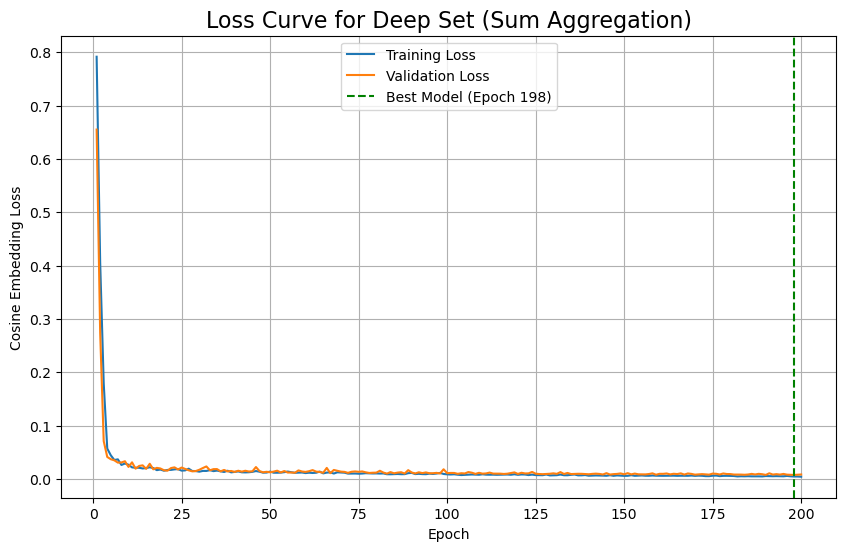


--- 7: Evaluating Best 'sum' Model on Test Set ---


Evaluating (sum): 100%|██████████| 16/16 [00:00<00:00, 25.71it/s]


Saved error vs events plot to 'error_vs_events_sum.png'


========================= TRAINING MODEL WITH 'MAX' AGGREGATION =========================

--- 4: Initializing Model (max) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/200 | Train Loss: 0.948095 | Val Loss: 0.641479


Epoch 2/200 | Train Loss: 0.560687 | Val Loss: 0.557210


Epoch 3/200 | Train Loss: 0.541129 | Val Loss: 0.566240


Epoch 4/200 | Train Loss: 0.488806 | Val Loss: 0.483130


Epoch 5/200 | Train Loss: 0.353671 | Val Loss: 0.255623


Epoch 6/200 | Train Loss: 0.197539 | Val Loss: 0.165158


Epoch 7/200 | Train Loss: 0.102081 | Val Loss: 0.100587


Epoch 8/200 | Train Loss: 0.074735 | Val Loss: 0.066697


Epoch 9/200 | Train Loss: 0.052448 | Val Loss: 0.063454


Epoch 10/200 | Train Loss: 0.044582 | Val Loss: 0.060542


Epoch 11/200 | Train Loss: 0.035744 | Val Loss: 0.044934


Epoch 12/200 | Train Loss: 0.033134 | Val Loss: 0.039114


Epoch 13/200 | Train Loss: 0.034552 | Val Loss: 0.038292


Epoch 14/200 | Train Loss: 0.030542 | Val Loss: 0.035917


Epoch 15/200 | Train Loss: 0.027327 | Val Loss: 0.036050


Epoch 16/200 | Train Loss: 0.023557 | Val Loss: 0.031902


Epoch 17/200 | Train Loss: 0.021137 | Val Loss: 0.034186


Epoch 18/200 | Train Loss: 0.024038 | Val Loss: 0.039412


Epoch 19/200 | Train Loss: 0.019990 | Val Loss: 0.033119


Epoch 20/200 | Train Loss: 0.019918 | Val Loss: 0.032543


Epoch 21/200 | Train Loss: 0.019382 | Val Loss: 0.038600


Epoch 22/200 | Train Loss: 0.017920 | Val Loss: 0.031770


Epoch 23/200 | Train Loss: 0.019403 | Val Loss: 0.032289


Epoch 24/200 | Train Loss: 0.016483 | Val Loss: 0.029648


Epoch 25/200 | Train Loss: 0.014580 | Val Loss: 0.032899


Epoch 26/200 | Train Loss: 0.014699 | Val Loss: 0.030609


Epoch 27/200 | Train Loss: 0.014084 | Val Loss: 0.028363


Epoch 28/200 | Train Loss: 0.013687 | Val Loss: 0.035737


Epoch 29/200 | Train Loss: 0.017668 | Val Loss: 0.031313


Epoch 30/200 | Train Loss: 0.014383 | Val Loss: 0.029594


Epoch 31/200 | Train Loss: 0.011933 | Val Loss: 0.030459


Epoch 32/200 | Train Loss: 0.012728 | Val Loss: 0.026603


Epoch 33/200 | Train Loss: 0.012484 | Val Loss: 0.033409


Epoch 34/200 | Train Loss: 0.012581 | Val Loss: 0.031865


Epoch 35/200 | Train Loss: 0.012122 | Val Loss: 0.025999


Epoch 36/200 | Train Loss: 0.010360 | Val Loss: 0.027770


Epoch 37/200 | Train Loss: 0.009317 | Val Loss: 0.026597


Epoch 38/200 | Train Loss: 0.010632 | Val Loss: 0.025914


Epoch 39/200 | Train Loss: 0.008565 | Val Loss: 0.025830


Epoch 40/200 | Train Loss: 0.007919 | Val Loss: 0.026450


Epoch 41/200 | Train Loss: 0.008979 | Val Loss: 0.031938


Epoch 42/200 | Train Loss: 0.010128 | Val Loss: 0.029005


Epoch 43/200 | Train Loss: 0.011206 | Val Loss: 0.028469


Epoch 44/200 | Train Loss: 0.007832 | Val Loss: 0.030340


Epoch 45/200 | Train Loss: 0.009232 | Val Loss: 0.027320


Epoch 46/200 | Train Loss: 0.008363 | Val Loss: 0.025204


Epoch 47/200 | Train Loss: 0.009008 | Val Loss: 0.026964


Epoch 48/200 | Train Loss: 0.007613 | Val Loss: 0.025669


Epoch 49/200 | Train Loss: 0.006687 | Val Loss: 0.024815


Epoch 50/200 | Train Loss: 0.005676 | Val Loss: 0.025313


Epoch 51/200 | Train Loss: 0.006575 | Val Loss: 0.026825


Epoch 52/200 | Train Loss: 0.006721 | Val Loss: 0.026981


Epoch 53/200 | Train Loss: 0.005626 | Val Loss: 0.026586


Epoch 54/200 | Train Loss: 0.005742 | Val Loss: 0.027132


Epoch 55/200 | Train Loss: 0.008263 | Val Loss: 0.025557


Epoch 56/200 | Train Loss: 0.006521 | Val Loss: 0.026359


Epoch 57/200 | Train Loss: 0.006044 | Val Loss: 0.025840


Epoch 58/200 | Train Loss: 0.005348 | Val Loss: 0.032233


Epoch 59/200 | Train Loss: 0.005219 | Val Loss: 0.027923


Epoch 60/200 | Train Loss: 0.005224 | Val Loss: 0.027044


Epoch 61/200 | Train Loss: 0.005372 | Val Loss: 0.025422


Epoch 62/200 | Train Loss: 0.004677 | Val Loss: 0.024785


Epoch 63/200 | Train Loss: 0.003522 | Val Loss: 0.025918


Epoch 64/200 | Train Loss: 0.005813 | Val Loss: 0.026879


Epoch 65/200 | Train Loss: 0.004957 | Val Loss: 0.026385


Epoch 66/200 | Train Loss: 0.003785 | Val Loss: 0.024875


Epoch 67/200 | Train Loss: 0.003268 | Val Loss: 0.025198


Epoch 68/200 | Train Loss: 0.003475 | Val Loss: 0.025739


Epoch 69/200 | Train Loss: 0.003429 | Val Loss: 0.024415


Epoch 70/200 | Train Loss: 0.004002 | Val Loss: 0.024839


Epoch 71/200 | Train Loss: 0.004582 | Val Loss: 0.025207


Epoch 72/200 | Train Loss: 0.004546 | Val Loss: 0.026769


Epoch 73/200 | Train Loss: 0.003114 | Val Loss: 0.026630


Epoch 74/200 | Train Loss: 0.003140 | Val Loss: 0.025753


Epoch 75/200 | Train Loss: 0.003356 | Val Loss: 0.025946


Epoch 76/200 | Train Loss: 0.004821 | Val Loss: 0.027434


Epoch 77/200 | Train Loss: 0.003967 | Val Loss: 0.024988


Epoch 78/200 | Train Loss: 0.003549 | Val Loss: 0.025822


Epoch 79/200 | Train Loss: 0.003566 | Val Loss: 0.026492


Epoch 80/200 | Train Loss: 0.003118 | Val Loss: 0.026133


Epoch 81/200 | Train Loss: 0.002863 | Val Loss: 0.024681


Epoch 82/200 | Train Loss: 0.003030 | Val Loss: 0.034239


Epoch 83/200 | Train Loss: 0.002775 | Val Loss: 0.025448


Epoch 84/200 | Train Loss: 0.002465 | Val Loss: 0.024984


Epoch 85/200 | Train Loss: 0.002228 | Val Loss: 0.025196


Epoch 86/200 | Train Loss: 0.002992 | Val Loss: 0.025855


Epoch 87/200 | Train Loss: 0.002444 | Val Loss: 0.026366


Epoch 88/200 | Train Loss: 0.002412 | Val Loss: 0.024944


Epoch 89/200 | Train Loss: 0.002266 | Val Loss: 0.025243


Epoch 90/200 | Train Loss: 0.001795 | Val Loss: 0.024492


Epoch 91/200 | Train Loss: 0.002714 | Val Loss: 0.025211


Epoch 92/200 | Train Loss: 0.001806 | Val Loss: 0.024693


Epoch 93/200 | Train Loss: 0.002085 | Val Loss: 0.026145


Epoch 94/200 | Train Loss: 0.002875 | Val Loss: 0.025958


Epoch 95/200 | Train Loss: 0.002339 | Val Loss: 0.027218


Epoch 96/200 | Train Loss: 0.002351 | Val Loss: 0.024663


Epoch 97/200 | Train Loss: 0.001966 | Val Loss: 0.024985


Epoch 98/200 | Train Loss: 0.001705 | Val Loss: 0.024676


Epoch 99/200 | Train Loss: 0.001410 | Val Loss: 0.026219


Epoch 100/200 | Train Loss: 0.001497 | Val Loss: 0.024531


Epoch 101/200 | Train Loss: 0.002643 | Val Loss: 0.025224


Epoch 102/200 | Train Loss: 0.001766 | Val Loss: 0.025183


Epoch 103/200 | Train Loss: 0.001848 | Val Loss: 0.024786


Epoch 104/200 | Train Loss: 0.001222 | Val Loss: 0.024444


Epoch 105/200 | Train Loss: 0.001515 | Val Loss: 0.024377


Epoch 106/200 | Train Loss: 0.001489 | Val Loss: 0.024927


Epoch 107/200 | Train Loss: 0.003612 | Val Loss: 0.025277


Epoch 108/200 | Train Loss: 0.002863 | Val Loss: 0.024702


Epoch 109/200 | Train Loss: 0.002620 | Val Loss: 0.023976


Epoch 110/200 | Train Loss: 0.001406 | Val Loss: 0.024166


Epoch 111/200 | Train Loss: 0.001444 | Val Loss: 0.025661


Epoch 112/200 | Train Loss: 0.001480 | Val Loss: 0.026912


Epoch 113/200 | Train Loss: 0.001686 | Val Loss: 0.024647


Epoch 114/200 | Train Loss: 0.001600 | Val Loss: 0.025121


Epoch 115/200 | Train Loss: 0.001327 | Val Loss: 0.025603


Epoch 116/200 | Train Loss: 0.001455 | Val Loss: 0.024838


Epoch 117/200 | Train Loss: 0.001358 | Val Loss: 0.026292


Epoch 118/200 | Train Loss: 0.001512 | Val Loss: 0.025563


Epoch 119/200 | Train Loss: 0.001085 | Val Loss: 0.024918


Epoch 120/200 | Train Loss: 0.001007 | Val Loss: 0.024117


Epoch 121/200 | Train Loss: 0.001118 | Val Loss: 0.024934


Epoch 122/200 | Train Loss: 0.001335 | Val Loss: 0.024481


Epoch 123/200 | Train Loss: 0.001151 | Val Loss: 0.024548


Epoch 124/200 | Train Loss: 0.001317 | Val Loss: 0.025290


Epoch 125/200 | Train Loss: 0.001417 | Val Loss: 0.024531


Epoch 126/200 | Train Loss: 0.000795 | Val Loss: 0.024719


Epoch 127/200 | Train Loss: 0.002257 | Val Loss: 0.024664


Epoch 128/200 | Train Loss: 0.002189 | Val Loss: 0.024802


Epoch 129/200 | Train Loss: 0.001346 | Val Loss: 0.024359


Epoch 130/200 | Train Loss: 0.000878 | Val Loss: 0.024780


Epoch 131/200 | Train Loss: 0.001148 | Val Loss: 0.025303


Epoch 132/200 | Train Loss: 0.001623 | Val Loss: 0.024679


Epoch 133/200 | Train Loss: 0.001405 | Val Loss: 0.024027


Epoch 134/200 | Train Loss: 0.001200 | Val Loss: 0.023859


Epoch 135/200 | Train Loss: 0.000878 | Val Loss: 0.024214


Epoch 136/200 | Train Loss: 0.000692 | Val Loss: 0.023797


Epoch 137/200 | Train Loss: 0.000726 | Val Loss: 0.024293


Epoch 138/200 | Train Loss: 0.000851 | Val Loss: 0.024123


Epoch 139/200 | Train Loss: 0.001773 | Val Loss: 0.023623


Epoch 140/200 | Train Loss: 0.001279 | Val Loss: 0.023989


Epoch 141/200 | Train Loss: 0.001955 | Val Loss: 0.023988


Epoch 142/200 | Train Loss: 0.001210 | Val Loss: 0.025621


Epoch 143/200 | Train Loss: 0.001027 | Val Loss: 0.023966


Epoch 144/200 | Train Loss: 0.000936 | Val Loss: 0.024160


Epoch 145/200 | Train Loss: 0.003729 | Val Loss: 0.027287


Epoch 146/200 | Train Loss: 0.001898 | Val Loss: 0.023597


Epoch 147/200 | Train Loss: 0.000548 | Val Loss: 0.023630


Epoch 148/200 | Train Loss: 0.000761 | Val Loss: 0.023490


Epoch 149/200 | Train Loss: 0.000863 | Val Loss: 0.024606


Epoch 150/200 | Train Loss: 0.001254 | Val Loss: 0.023808


Epoch 151/200 | Train Loss: 0.000805 | Val Loss: 0.024230


Epoch 152/200 | Train Loss: 0.001154 | Val Loss: 0.023489


Epoch 153/200 | Train Loss: 0.000711 | Val Loss: 0.026451


Epoch 154/200 | Train Loss: 0.001233 | Val Loss: 0.024455


Epoch 155/200 | Train Loss: 0.000681 | Val Loss: 0.023527


Epoch 156/200 | Train Loss: 0.000816 | Val Loss: 0.025079


Epoch 157/200 | Train Loss: 0.000821 | Val Loss: 0.024455


Epoch 158/200 | Train Loss: 0.000625 | Val Loss: 0.024641


Epoch 159/200 | Train Loss: 0.001007 | Val Loss: 0.023657


Epoch 160/200 | Train Loss: 0.001502 | Val Loss: 0.025922


Epoch 161/200 | Train Loss: 0.000703 | Val Loss: 0.023371


Epoch 162/200 | Train Loss: 0.000721 | Val Loss: 0.024544


Epoch 163/200 | Train Loss: 0.000727 | Val Loss: 0.023782


Epoch 164/200 | Train Loss: 0.000583 | Val Loss: 0.023724


Epoch 165/200 | Train Loss: 0.001006 | Val Loss: 0.024291


Epoch 166/200 | Train Loss: 0.001117 | Val Loss: 0.025599


Epoch 167/200 | Train Loss: 0.002413 | Val Loss: 0.027940


Epoch 168/200 | Train Loss: 0.001559 | Val Loss: 0.026073


Epoch 169/200 | Train Loss: 0.001099 | Val Loss: 0.024709


Epoch 170/200 | Train Loss: 0.000982 | Val Loss: 0.023628


Epoch 171/200 | Train Loss: 0.000385 | Val Loss: 0.023164


Epoch 172/200 | Train Loss: 0.000306 | Val Loss: 0.023184


Epoch 173/200 | Train Loss: 0.000408 | Val Loss: 0.023362


Epoch 174/200 | Train Loss: 0.000536 | Val Loss: 0.024067


Epoch 175/200 | Train Loss: 0.001539 | Val Loss: 0.023533


Epoch 176/200 | Train Loss: 0.001077 | Val Loss: 0.024401


Epoch 177/200 | Train Loss: 0.001096 | Val Loss: 0.023635


Epoch 178/200 | Train Loss: 0.000996 | Val Loss: 0.027448


Epoch 179/200 | Train Loss: 0.002669 | Val Loss: 0.027758


Epoch 180/200 | Train Loss: 0.002848 | Val Loss: 0.023457


Epoch 181/200 | Train Loss: 0.001263 | Val Loss: 0.027928


Epoch 182/200 | Train Loss: 0.000918 | Val Loss: 0.023101


Epoch 183/200 | Train Loss: 0.000337 | Val Loss: 0.023603


Epoch 184/200 | Train Loss: 0.000554 | Val Loss: 0.023571


Epoch 185/200 | Train Loss: 0.000436 | Val Loss: 0.023209


Epoch 186/200 | Train Loss: 0.000354 | Val Loss: 0.023093


Epoch 187/200 | Train Loss: 0.000254 | Val Loss: 0.022929


Epoch 188/200 | Train Loss: 0.000220 | Val Loss: 0.023004


Epoch 189/200 | Train Loss: 0.000242 | Val Loss: 0.023103


Epoch 190/200 | Train Loss: 0.000370 | Val Loss: 0.023598


Epoch 191/200 | Train Loss: 0.000405 | Val Loss: 0.023786


Epoch 192/200 | Train Loss: 0.000516 | Val Loss: 0.023483


Epoch 193/200 | Train Loss: 0.000825 | Val Loss: 0.024740


Epoch 194/200 | Train Loss: 0.001664 | Val Loss: 0.023233


Epoch 195/200 | Train Loss: 0.000973 | Val Loss: 0.022921


Epoch 196/200 | Train Loss: 0.000378 | Val Loss: 0.023214


Epoch 197/200 | Train Loss: 0.000740 | Val Loss: 0.023052


Epoch 198/200 | Train Loss: 0.000703 | Val Loss: 0.023258


Epoch 199/200 | Train Loss: 0.000535 | Val Loss: 0.023054


Epoch 200/200 | Train Loss: 0.001645 | Val Loss: 0.023329

--- Training Complete for 'max' model. Best epoch: 195 (Val Loss: 0.022921) ---

--- 6: Displaying Loss Curve Plot for 'max' model ---


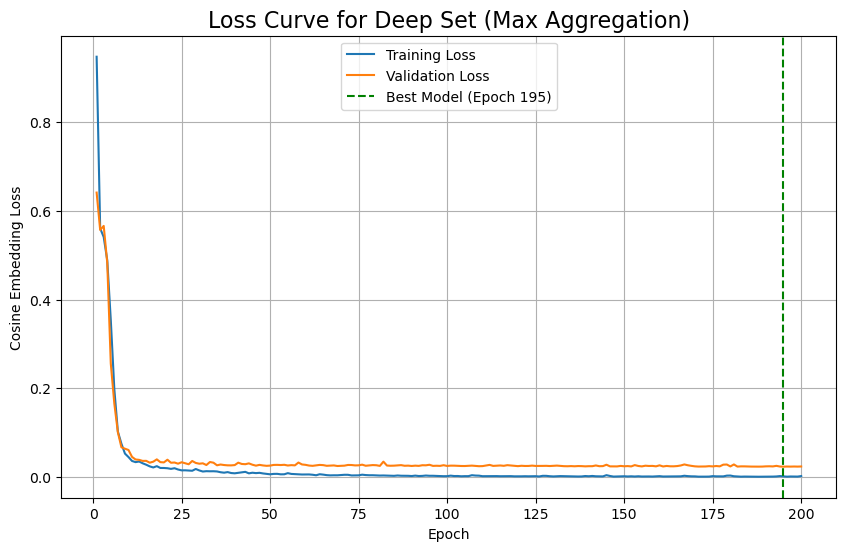


--- 7: Evaluating Best 'max' Model on Test Set ---


Evaluating (max): 100%|██████████| 16/16 [00:00<00:00, 25.47it/s]


Saved error vs events plot to 'error_vs_events_max.png'


========================= TRAINING MODEL WITH 'MEAN' AGGREGATION =========================

--- 4: Initializing Model (mean) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/200 | Train Loss: 0.946755 | Val Loss: 0.715031


Epoch 2/200 | Train Loss: 0.532967 | Val Loss: 0.535290


Epoch 3/200 | Train Loss: 0.502713 | Val Loss: 0.489668


Epoch 4/200 | Train Loss: 0.470649 | Val Loss: 0.422245


Epoch 5/200 | Train Loss: 0.328955 | Val Loss: 0.411349


Epoch 6/200 | Train Loss: 0.150052 | Val Loss: 0.082629


Epoch 7/200 | Train Loss: 0.058441 | Val Loss: 0.040364


Epoch 8/200 | Train Loss: 0.040419 | Val Loss: 0.043822


Epoch 9/200 | Train Loss: 0.037018 | Val Loss: 0.035147


Epoch 10/200 | Train Loss: 0.032264 | Val Loss: 0.037329


Epoch 11/200 | Train Loss: 0.032784 | Val Loss: 0.028506


Epoch 12/200 | Train Loss: 0.028716 | Val Loss: 0.028860


Epoch 13/200 | Train Loss: 0.030375 | Val Loss: 0.027353


Epoch 14/200 | Train Loss: 0.027874 | Val Loss: 0.025893


Epoch 15/200 | Train Loss: 0.024440 | Val Loss: 0.029182


Epoch 16/200 | Train Loss: 0.023542 | Val Loss: 0.025872


Epoch 17/200 | Train Loss: 0.026610 | Val Loss: 0.022181


Epoch 18/200 | Train Loss: 0.022211 | Val Loss: 0.028036


Epoch 19/200 | Train Loss: 0.019913 | Val Loss: 0.019868


Epoch 20/200 | Train Loss: 0.019733 | Val Loss: 0.021102


Epoch 21/200 | Train Loss: 0.021397 | Val Loss: 0.030675


Epoch 22/200 | Train Loss: 0.019297 | Val Loss: 0.018528


Epoch 23/200 | Train Loss: 0.020763 | Val Loss: 0.018459


Epoch 24/200 | Train Loss: 0.018694 | Val Loss: 0.018506


Epoch 25/200 | Train Loss: 0.019409 | Val Loss: 0.021196


Epoch 26/200 | Train Loss: 0.020281 | Val Loss: 0.018265


Epoch 27/200 | Train Loss: 0.016454 | Val Loss: 0.017845


Epoch 28/200 | Train Loss: 0.016927 | Val Loss: 0.020864


Epoch 29/200 | Train Loss: 0.018198 | Val Loss: 0.019797


Epoch 30/200 | Train Loss: 0.017234 | Val Loss: 0.018107


Epoch 31/200 | Train Loss: 0.017529 | Val Loss: 0.018828


Epoch 32/200 | Train Loss: 0.017226 | Val Loss: 0.021145


Epoch 33/200 | Train Loss: 0.016853 | Val Loss: 0.017182


Epoch 34/200 | Train Loss: 0.015456 | Val Loss: 0.016966


Epoch 35/200 | Train Loss: 0.015623 | Val Loss: 0.019522


Epoch 36/200 | Train Loss: 0.015579 | Val Loss: 0.016075


Epoch 37/200 | Train Loss: 0.015651 | Val Loss: 0.015694


Epoch 38/200 | Train Loss: 0.016527 | Val Loss: 0.020652


Epoch 39/200 | Train Loss: 0.016223 | Val Loss: 0.016881


Epoch 40/200 | Train Loss: 0.017226 | Val Loss: 0.022939


Epoch 41/200 | Train Loss: 0.015564 | Val Loss: 0.017272


Epoch 42/200 | Train Loss: 0.014450 | Val Loss: 0.014477


Epoch 43/200 | Train Loss: 0.015043 | Val Loss: 0.017107


Epoch 44/200 | Train Loss: 0.013697 | Val Loss: 0.018870


Epoch 45/200 | Train Loss: 0.014161 | Val Loss: 0.015685


Epoch 46/200 | Train Loss: 0.014004 | Val Loss: 0.014448


Epoch 47/200 | Train Loss: 0.015533 | Val Loss: 0.014377


Epoch 48/200 | Train Loss: 0.014521 | Val Loss: 0.013677


Epoch 49/200 | Train Loss: 0.012971 | Val Loss: 0.019048


Epoch 50/200 | Train Loss: 0.014091 | Val Loss: 0.015615


Epoch 51/200 | Train Loss: 0.016940 | Val Loss: 0.021457


Epoch 52/200 | Train Loss: 0.014519 | Val Loss: 0.017877


Epoch 53/200 | Train Loss: 0.013868 | Val Loss: 0.016340


Epoch 54/200 | Train Loss: 0.012354 | Val Loss: 0.015632


Epoch 55/200 | Train Loss: 0.013830 | Val Loss: 0.016295


Epoch 56/200 | Train Loss: 0.013080 | Val Loss: 0.014731


Epoch 57/200 | Train Loss: 0.013647 | Val Loss: 0.016828


Epoch 58/200 | Train Loss: 0.013449 | Val Loss: 0.014341


Epoch 59/200 | Train Loss: 0.013828 | Val Loss: 0.014255


Epoch 60/200 | Train Loss: 0.012207 | Val Loss: 0.013094


Epoch 61/200 | Train Loss: 0.012466 | Val Loss: 0.015530


Epoch 62/200 | Train Loss: 0.013611 | Val Loss: 0.018740


Epoch 63/200 | Train Loss: 0.013159 | Val Loss: 0.017116


Epoch 64/200 | Train Loss: 0.012377 | Val Loss: 0.013745


Epoch 65/200 | Train Loss: 0.014057 | Val Loss: 0.017057


Epoch 66/200 | Train Loss: 0.012417 | Val Loss: 0.014057


Epoch 67/200 | Train Loss: 0.011982 | Val Loss: 0.012384


Epoch 68/200 | Train Loss: 0.012740 | Val Loss: 0.013555


Epoch 69/200 | Train Loss: 0.012917 | Val Loss: 0.017507


Epoch 70/200 | Train Loss: 0.012392 | Val Loss: 0.014053


Epoch 71/200 | Train Loss: 0.012246 | Val Loss: 0.016917


Epoch 72/200 | Train Loss: 0.012240 | Val Loss: 0.012339


Epoch 73/200 | Train Loss: 0.012918 | Val Loss: 0.013006


Epoch 74/200 | Train Loss: 0.011442 | Val Loss: 0.013345


Epoch 75/200 | Train Loss: 0.011633 | Val Loss: 0.012552


Epoch 76/200 | Train Loss: 0.011725 | Val Loss: 0.013363


Epoch 77/200 | Train Loss: 0.011562 | Val Loss: 0.012149


Epoch 78/200 | Train Loss: 0.011217 | Val Loss: 0.015488


Epoch 79/200 | Train Loss: 0.011968 | Val Loss: 0.012698


Epoch 80/200 | Train Loss: 0.010942 | Val Loss: 0.019610


Epoch 81/200 | Train Loss: 0.013012 | Val Loss: 0.013348


Epoch 82/200 | Train Loss: 0.010930 | Val Loss: 0.013758


Epoch 83/200 | Train Loss: 0.011010 | Val Loss: 0.013351


Epoch 84/200 | Train Loss: 0.011538 | Val Loss: 0.013032


Epoch 85/200 | Train Loss: 0.011128 | Val Loss: 0.015616


Epoch 86/200 | Train Loss: 0.010557 | Val Loss: 0.012452


Epoch 87/200 | Train Loss: 0.010514 | Val Loss: 0.012380


Epoch 88/200 | Train Loss: 0.010226 | Val Loss: 0.011433


Epoch 89/200 | Train Loss: 0.011506 | Val Loss: 0.013087


Epoch 90/200 | Train Loss: 0.010206 | Val Loss: 0.012370


Epoch 91/200 | Train Loss: 0.010431 | Val Loss: 0.014361


Epoch 92/200 | Train Loss: 0.012696 | Val Loss: 0.011296


Epoch 93/200 | Train Loss: 0.011319 | Val Loss: 0.011650


Epoch 94/200 | Train Loss: 0.010543 | Val Loss: 0.011711


Epoch 95/200 | Train Loss: 0.010014 | Val Loss: 0.014205


Epoch 96/200 | Train Loss: 0.010358 | Val Loss: 0.011844


Epoch 97/200 | Train Loss: 0.010215 | Val Loss: 0.011524


Epoch 98/200 | Train Loss: 0.010291 | Val Loss: 0.012774


Epoch 99/200 | Train Loss: 0.010389 | Val Loss: 0.016873


Epoch 100/200 | Train Loss: 0.010911 | Val Loss: 0.011430


Epoch 101/200 | Train Loss: 0.009734 | Val Loss: 0.012101


Epoch 102/200 | Train Loss: 0.010840 | Val Loss: 0.010920


Epoch 103/200 | Train Loss: 0.009624 | Val Loss: 0.013510


Epoch 104/200 | Train Loss: 0.010529 | Val Loss: 0.011867


Epoch 105/200 | Train Loss: 0.009309 | Val Loss: 0.011343


Epoch 106/200 | Train Loss: 0.010343 | Val Loss: 0.015257


Epoch 107/200 | Train Loss: 0.011380 | Val Loss: 0.011904


Epoch 108/200 | Train Loss: 0.008951 | Val Loss: 0.010269


Epoch 109/200 | Train Loss: 0.009203 | Val Loss: 0.011602


Epoch 110/200 | Train Loss: 0.009802 | Val Loss: 0.010340


Epoch 111/200 | Train Loss: 0.009263 | Val Loss: 0.010249


Epoch 112/200 | Train Loss: 0.009277 | Val Loss: 0.011033


Epoch 113/200 | Train Loss: 0.008600 | Val Loss: 0.010741


Epoch 114/200 | Train Loss: 0.008784 | Val Loss: 0.010124


Epoch 115/200 | Train Loss: 0.009502 | Val Loss: 0.013221


Epoch 116/200 | Train Loss: 0.009668 | Val Loss: 0.010369


Epoch 117/200 | Train Loss: 0.008913 | Val Loss: 0.010214


Epoch 118/200 | Train Loss: 0.009352 | Val Loss: 0.010888


Epoch 119/200 | Train Loss: 0.009579 | Val Loss: 0.013545


Epoch 120/200 | Train Loss: 0.009267 | Val Loss: 0.011176


Epoch 121/200 | Train Loss: 0.010347 | Val Loss: 0.012125


Epoch 122/200 | Train Loss: 0.010087 | Val Loss: 0.012480


Epoch 123/200 | Train Loss: 0.009332 | Val Loss: 0.010862


Epoch 124/200 | Train Loss: 0.009778 | Val Loss: 0.011326


Epoch 125/200 | Train Loss: 0.008801 | Val Loss: 0.009963


Epoch 126/200 | Train Loss: 0.009473 | Val Loss: 0.012140


Epoch 127/200 | Train Loss: 0.008319 | Val Loss: 0.010540


Epoch 128/200 | Train Loss: 0.008742 | Val Loss: 0.011057


Epoch 129/200 | Train Loss: 0.008779 | Val Loss: 0.010427


Epoch 130/200 | Train Loss: 0.009076 | Val Loss: 0.009877


Epoch 131/200 | Train Loss: 0.010116 | Val Loss: 0.010638


Epoch 132/200 | Train Loss: 0.008258 | Val Loss: 0.010428


Epoch 133/200 | Train Loss: 0.008230 | Val Loss: 0.009820


Epoch 134/200 | Train Loss: 0.008621 | Val Loss: 0.013195


Epoch 135/200 | Train Loss: 0.008284 | Val Loss: 0.010719


Epoch 136/200 | Train Loss: 0.009196 | Val Loss: 0.012112


Epoch 137/200 | Train Loss: 0.007889 | Val Loss: 0.009640


Epoch 138/200 | Train Loss: 0.008217 | Val Loss: 0.009848


Epoch 139/200 | Train Loss: 0.008150 | Val Loss: 0.010694


Epoch 140/200 | Train Loss: 0.007979 | Val Loss: 0.010887


Epoch 141/200 | Train Loss: 0.008609 | Val Loss: 0.012266


Epoch 142/200 | Train Loss: 0.008566 | Val Loss: 0.012196


Epoch 143/200 | Train Loss: 0.008081 | Val Loss: 0.010662


Epoch 144/200 | Train Loss: 0.007439 | Val Loss: 0.010409


Epoch 145/200 | Train Loss: 0.008093 | Val Loss: 0.015346


Epoch 146/200 | Train Loss: 0.008453 | Val Loss: 0.009961


Epoch 147/200 | Train Loss: 0.008096 | Val Loss: 0.009742


Epoch 148/200 | Train Loss: 0.008057 | Val Loss: 0.016020


Epoch 149/200 | Train Loss: 0.008556 | Val Loss: 0.014472


Epoch 150/200 | Train Loss: 0.007691 | Val Loss: 0.009723


Epoch 151/200 | Train Loss: 0.008416 | Val Loss: 0.011401


Epoch 152/200 | Train Loss: 0.007480 | Val Loss: 0.009880


Epoch 153/200 | Train Loss: 0.007782 | Val Loss: 0.009519


Epoch 154/200 | Train Loss: 0.007414 | Val Loss: 0.009687


Epoch 155/200 | Train Loss: 0.007330 | Val Loss: 0.008900


Epoch 156/200 | Train Loss: 0.008716 | Val Loss: 0.010481


Epoch 157/200 | Train Loss: 0.008570 | Val Loss: 0.009338


Epoch 158/200 | Train Loss: 0.007472 | Val Loss: 0.009481


Epoch 159/200 | Train Loss: 0.007376 | Val Loss: 0.009689


Epoch 160/200 | Train Loss: 0.007858 | Val Loss: 0.012953


Epoch 161/200 | Train Loss: 0.007881 | Val Loss: 0.010268


Epoch 162/200 | Train Loss: 0.007260 | Val Loss: 0.009063


Epoch 163/200 | Train Loss: 0.007664 | Val Loss: 0.012295


Epoch 164/200 | Train Loss: 0.007951 | Val Loss: 0.010121


Epoch 165/200 | Train Loss: 0.007684 | Val Loss: 0.012499


Epoch 166/200 | Train Loss: 0.007680 | Val Loss: 0.010979


Epoch 167/200 | Train Loss: 0.007243 | Val Loss: 0.010421


Epoch 168/200 | Train Loss: 0.007553 | Val Loss: 0.009915


Epoch 169/200 | Train Loss: 0.007424 | Val Loss: 0.010111


Epoch 170/200 | Train Loss: 0.007562 | Val Loss: 0.010109


Epoch 171/200 | Train Loss: 0.007323 | Val Loss: 0.010345


Epoch 172/200 | Train Loss: 0.007916 | Val Loss: 0.009824


Epoch 173/200 | Train Loss: 0.007198 | Val Loss: 0.009637


Epoch 174/200 | Train Loss: 0.006615 | Val Loss: 0.009298


Epoch 175/200 | Train Loss: 0.008131 | Val Loss: 0.014021


Epoch 176/200 | Train Loss: 0.007268 | Val Loss: 0.009338


Epoch 177/200 | Train Loss: 0.007267 | Val Loss: 0.012493


Epoch 178/200 | Train Loss: 0.008080 | Val Loss: 0.008955


Epoch 179/200 | Train Loss: 0.006997 | Val Loss: 0.009331


Epoch 180/200 | Train Loss: 0.007220 | Val Loss: 0.009434


Epoch 181/200 | Train Loss: 0.007357 | Val Loss: 0.009024


Epoch 182/200 | Train Loss: 0.006584 | Val Loss: 0.009240


Epoch 183/200 | Train Loss: 0.006790 | Val Loss: 0.010259


Epoch 184/200 | Train Loss: 0.006872 | Val Loss: 0.009062


Epoch 185/200 | Train Loss: 0.006736 | Val Loss: 0.008889


Epoch 186/200 | Train Loss: 0.007429 | Val Loss: 0.009783


Epoch 187/200 | Train Loss: 0.007664 | Val Loss: 0.011029


Epoch 188/200 | Train Loss: 0.008562 | Val Loss: 0.010089


Epoch 189/200 | Train Loss: 0.006503 | Val Loss: 0.009046


Epoch 190/200 | Train Loss: 0.006496 | Val Loss: 0.009027


Epoch 191/200 | Train Loss: 0.006865 | Val Loss: 0.010123


Epoch 192/200 | Train Loss: 0.006957 | Val Loss: 0.009057


Epoch 193/200 | Train Loss: 0.006498 | Val Loss: 0.010188


Epoch 194/200 | Train Loss: 0.006523 | Val Loss: 0.009988


Epoch 195/200 | Train Loss: 0.006617 | Val Loss: 0.009446


Epoch 196/200 | Train Loss: 0.006655 | Val Loss: 0.010008


Epoch 197/200 | Train Loss: 0.006967 | Val Loss: 0.009559


Epoch 198/200 | Train Loss: 0.006613 | Val Loss: 0.009125


Epoch 199/200 | Train Loss: 0.006511 | Val Loss: 0.011087


Epoch 200/200 | Train Loss: 0.007101 | Val Loss: 0.008828

--- Training Complete for 'mean' model. Best epoch: 200 (Val Loss: 0.008828) ---

--- 6: Displaying Loss Curve Plot for 'mean' model ---


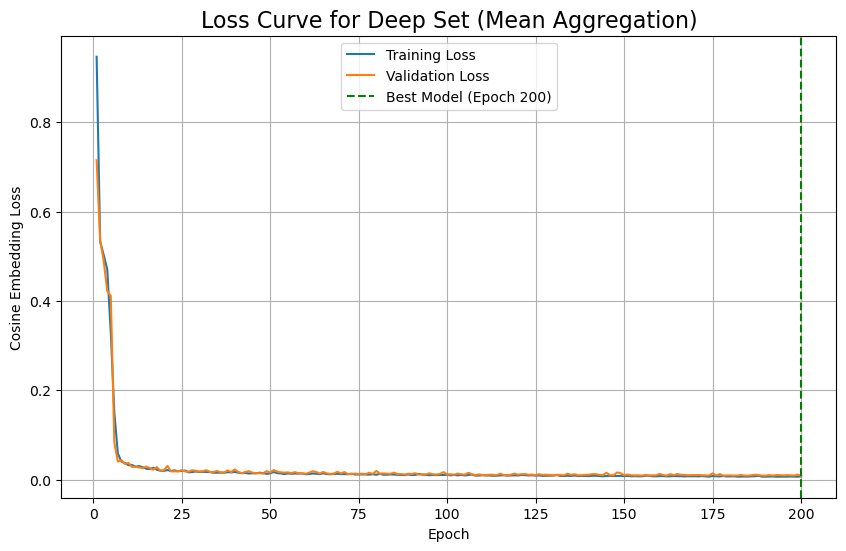


--- 7: Evaluating Best 'mean' Model on Test Set ---


Evaluating (mean): 100%|██████████| 16/16 [00:00<00:00, 25.37it/s]


Saved error vs events plot to 'error_vs_events_mean.png'


============================== FINAL RESULTS SUMMARY ==============================

--- Model Performance on Test Set ---
Model                     Mean Angular Error        Median Angular Error     
---------------------------------------------------------------------------
Deep Sets (Sum)           5.1679 degrees            3.7841 degrees           
Deep Sets (Max)           9.8959 degrees            8.3087 degrees           
Deep Sets (Mean)          5.5195 degrees            3.8880 degrees           
LMMLEM (Baseline)         6.6815                    degrees 0.7193                    degrees

--- Detailed Sample Predictions (l, b in degrees) ---

----------- Sample 1 -----------
  - Ground Truth        : ( 127.16,  21.47)
  - LMMLEM Pred         : ( 127.50,  22.50) -> Error: 1.08°
  - Deep Sets (Sum)     : ( 119.02,  27.92) -> Error: 9.81°
  - Deep Sets (Max)     : ( 127.92,  33.46) -> Error: 12.01°
  - Deep Sets (Mean)  

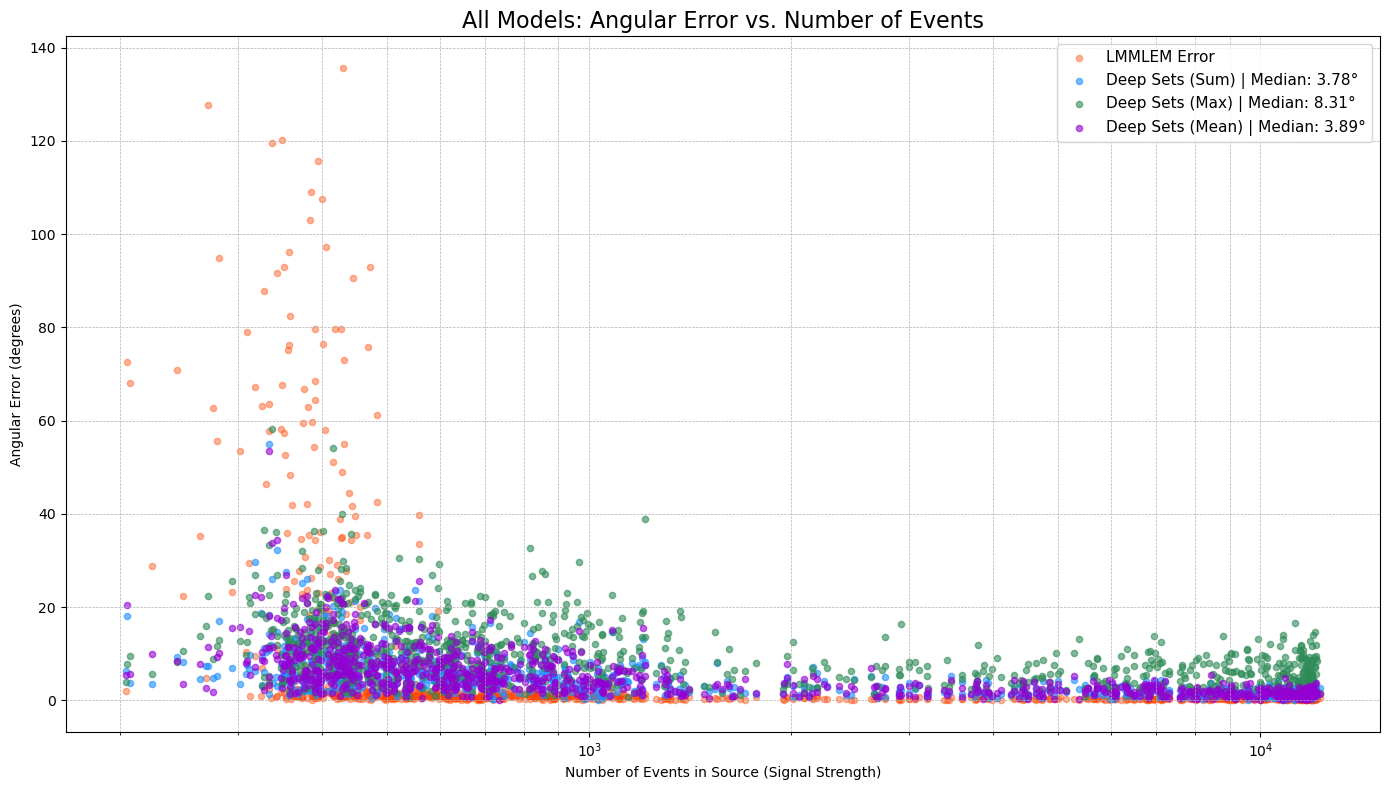

In [5]:
# ===================================================================
#                        4. MAIN SCRIPT
# ===================================================================

if __name__ == '__main__':
    # --- Configuration ---
    ANGULAR_FEATURE_INDICES = [1, 3, 4] 
    PHI_HIDDEN_DIMS = [128, 256, 512]
    LATENT_DIM = 1024
    RHO_HIDDEN_DIMS = [512, 256, 128, 64]
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 64
    EPOCHS = 200
    DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
    AGGREGATION_TYPES = ['sum', 'max', 'mean']

    # --- 1. Load and Preprocess Data ---
    print("--- 1: Loading and Preprocessing Data ---")
    x_events_raw = np.load("./All_Events_SignalBkg5_Deg.npy", allow_pickle=True)
    y_coords = np.load("./Ground_Truths.npy", allow_pickle=True)
    y_lon_lat_deg_true = np.array(y_coords[:, 1:3], dtype=np.float32)
    y_lon_lat_deg_lmmlem = np.array(y_coords[:, 3:5], dtype=np.float32)
    x_events_transformed = transform_event_features(x_events_raw, ANGULAR_FEATURE_INDICES)
    y_cartesian_true = convert_to_cartesian(y_lon_lat_deg_true)
    
    # --- 2. Create Splits and Fit Scaler ---
    print("\n--- 2: Creating Data Splits and Scaler ---")
    x_raw_train_val, x_raw_test, x_train_val, x_test, y_train_val, y_test, y_train_val_lb, y_test_lb, y_lmmlem_train_val, y_lmmlem_test = train_test_split(
        x_events_raw, x_events_transformed, y_cartesian_true, y_lon_lat_deg_true, y_lon_lat_deg_lmmlem,
        test_size=0.2, random_state=42)
    x_raw_train, x_raw_val, x_train, x_val, y_train, y_val, y_train_lb, y_val_lb, y_lmmlem_train, y_lmmlem_val = train_test_split(
        x_raw_train_val, x_train_val, y_train_val, y_train_val_lb, y_lmmlem_train_val,
        test_size=0.2, random_state=42)
    all_train_events = np.concatenate([events for events in x_train if events.shape[0] > 0])
    scaler = StandardScaler()
    scaler.fit(all_train_events)
    
    # --- 3. Create Datasets and DataLoaders ---
    print("\n--- 3: Setting up Datasets and DataLoaders ---")
    train_dataset = ComptonDataset(x_train, y_train, scaler)
    val_dataset = ComptonDataset(x_val, y_val, scaler)
    test_dataset = ComptonDataset(x_test, y_test, scaler)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    all_results = {}

    for agg_type in AGGREGATION_TYPES:
        print(f"\n\n{'='*25} TRAINING MODEL WITH '{agg_type.upper()}' AGGREGATION {'='*25}")

        # --- 4. Initialize Model ---
        print(f"\n--- 4: Initializing Model ({agg_type}) and Training Components ---")
        input_dim = all_train_events.shape[1]
        model = DeepSet(input_dim=input_dim, phi_hidden_dims=PHI_HIDDEN_DIMS, latent_dim=LATENT_DIM, rho_hidden_dims=RHO_HIDDEN_DIMS, agg_type=agg_type).to(DEVICE)
        criterion = nn.CosineEmbeddingLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print(f"Using device: {DEVICE}")
        
        # --- 5. Training Loop with Validation ---
        print("\n--- 5: Starting Training with Validation ---")
        train_losses, val_losses = [], []
        best_val_loss, best_epoch, best_model_state_dict = float('inf'), -1, None
        
        for epoch in range(EPOCHS):
            # --- Training Phase ---
            model.train()
            running_train_loss = 0.0
            # Use leave=False for a cleaner output
            for events_list, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False):
                events_list, targets = [e.to(DEVICE) for e in events_list], targets.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(events_list)
                loss = criterion(outputs, targets, torch.ones(outputs.shape[0]).to(DEVICE))
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # --- Validation Phase ---
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                # Use leave=False for a cleaner output
                for events_list, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]  ", leave=False):
                    events_list, targets = [e.to(DEVICE) for e in events_list], targets.to(DEVICE)
                    outputs = model(events_list)
                    loss = criterion(outputs, targets, torch.ones(outputs.shape[0]).to(DEVICE))
                    running_val_loss += loss.item()
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)

            # --- Print Epoch Results on a Single Line ---
            print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

            # --- Check for Best Model ---
            if epoch_val_loss < best_val_loss:
                best_val_loss, best_epoch, best_model_state_dict = epoch_val_loss, epoch + 1, copy.deepcopy(model.state_dict())
        
        print(f"\n--- Training Complete for '{agg_type}' model. Best epoch: {best_epoch} (Val Loss: {best_val_loss:.6f}) ---")

        # --- 6. Plot Loss Curves Directly ---
        print(f"\n--- 6: Displaying Loss Curve Plot for '{agg_type}' model ---")
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
        plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label=f'Best Model (Epoch {best_epoch})')
        plt.title(f'Loss Curve for Deep Set ({agg_type.capitalize()} Aggregation)', fontsize=16)
        plt.xlabel('Epoch'), plt.ylabel('Cosine Embedding Loss'), plt.legend(), plt.grid(True)
        plt.show() # This will display the plot and pause execution until it's closed

        # --- 7. Evaluation on Test Set ---
        print(f"\n--- 7: Evaluating Best '{agg_type}' Model on Test Set ---")
        if best_model_state_dict: model.load_state_dict(best_model_state_dict)
        model.eval()
        all_preds_cart, all_targets_cart = [], []
        with torch.no_grad():
            for events_list, targets in tqdm(test_loader, desc=f"Evaluating ({agg_type})"):
                events_list = [e.to(DEVICE) for e in events_list]
                all_preds_cart.append(model(events_list).cpu().numpy())
                all_targets_cart.append(targets.cpu().numpy())
        y_pred_cart_deepset = np.concatenate(all_preds_cart)
        y_true_cart_eval = np.concatenate(all_targets_cart)
        angular_errors_deepset = calculate_angular_error(y_true_cart_eval, y_pred_cart_deepset)

        all_results[agg_type] = {
            'predictions_cart': y_pred_cart_deepset,
            'errors': angular_errors_deepset,
            'mean_error': np.mean(angular_errors_deepset),
            'median_error': np.median(angular_errors_deepset)
        }
        
        # --- 8. Error vs Events Plot (Saved for later) ---
        test_event_counts = [len(events) for events in x_raw_test]
        y_pred_cart_lmmlem = convert_to_cartesian(y_lmmlem_test)
        angular_errors_lmmlem = calculate_angular_error(y_true_cart_eval, y_pred_cart_lmmlem)
        plt.figure(figsize=(12, 7))
        plt.scatter(test_event_counts, angular_errors_lmmlem, alpha=0.5, s=20, label='LMMLEM Error', c='orangered')
        plt.scatter(test_event_counts, angular_errors_deepset, alpha=0.5, s=20, label=f'Deep Sets ({agg_type.capitalize()}) Error', c='dodgerblue')
        plt.title(f'Model Error vs. Events ({agg_type.capitalize()} Aggregation)', fontsize=16)
        plt.xlabel('Number of Events'), plt.ylabel('Angular Error (degrees)'), plt.xscale('log'), plt.legend(), plt.grid(True, which='both', linestyle='--')
        plt.savefig(f"error_vs_events_{agg_type}.png")
        plt.close() # Close figure to avoid displaying it now
        print(f"Saved error vs events plot to 'error_vs_events_{agg_type}.png'")


    # ===================================================================
    #              9. FINAL SUMMARY AND COMPARISONS
    # ===================================================================
    print("\n\n" + "="*30 + " FINAL RESULTS SUMMARY " + "="*30)
    
    # --- Print Summary Table ---
    print("\n--- Model Performance on Test Set ---")
    print(f"{'Model':<25} {'Mean Angular Error':<25} {'Median Angular Error':<25}")
    print("-" * 75)
    for agg_type, results in all_results.items():
        model_name = f"Deep Sets ({agg_type.capitalize()})"
        mean_err = f"{results['mean_error']:.4f} degrees"
        median_err = f"{results['median_error']:.4f} degrees"
        print(f"{model_name:<25} {mean_err:<25} {median_err:<25}")
    mean_err_lmmlem, median_err_lmmlem = np.mean(angular_errors_lmmlem), np.median(angular_errors_lmmlem)
    print(f"{'LMMLEM (Baseline)':<25} {mean_err_lmmlem:<25.4f} degrees {median_err_lmmlem:<25.4f} degrees")
    print("=" * 78)

    # --- Print Detailed Sample Predictions ---
    print("\n--- Detailed Sample Predictions (l, b in degrees) ---")
    predictions_lb_all_models = {
        agg: convert_cartesian_to_lon_lat(res['predictions_cart']) for agg, res in all_results.items()
    }
    num_samples_to_show = min(5, len(y_test_lb))
    for i in range(num_samples_to_show):
        print(f"\n----------- Sample {i+1} -----------")
        true_l, true_b = y_test_lb[i]
        print(f"  - {'Ground Truth':<20}: ({true_l:7.2f}, {true_b:6.2f})")
        
        lmmlem_l, lmmlem_b = y_lmmlem_test[i]
        lmmlem_err = angular_errors_lmmlem[i]
        print(f"  - {'LMMLEM Pred':<20}: ({lmmlem_l:7.2f}, {lmmlem_b:6.2f}) -> Error: {lmmlem_err:.2f}°")
        
        for agg_type in AGGREGATION_TYPES:
            deepset_l, deepset_b = predictions_lb_all_models[agg_type][i]
            deepset_err = all_results[agg_type]['errors'][i]
            model_name_str = f"Deep Sets ({agg_type.capitalize()})"
            print(f"  - {model_name_str:<20}: ({deepset_l:7.2f}, {deepset_b:6.2f}) -> Error: {deepset_err:.2f}°")

    # --- Create and Display Final Comparison Plot ---
    print("\n\n--- Generating Final Comparison Plot ---")
    plt.figure(figsize=(14, 8))
    colors = {'sum': 'dodgerblue', 'max': 'seagreen', 'mean': 'darkviolet'}
    plt.scatter(test_event_counts, angular_errors_lmmlem, alpha=0.4, s=20, label='LMMLEM Error', c='orangered')
    for agg_type, results in all_results.items():
        plt.scatter(test_event_counts, results['errors'], alpha=0.6, s=20, 
                    label=f"Deep Sets ({agg_type.capitalize()}) | Median: {results['median_error']:.2f}°", 
                    c=colors[agg_type])
    plt.title('All Models: Angular Error vs. Number of Events', fontsize=16)
    plt.xlabel('Number of Events in Source (Signal Strength)'), plt.ylabel('Angular Error (degrees)'), plt.xscale('log')
    plt.legend(fontsize=11), plt.grid(True, which='both', linestyle='--', linewidth=0.5), plt.tight_layout()
    plt.savefig("error_comparison_all_models.png")
    print("\nGenerated final comparison plot and saved as 'error_comparison_all_models.png'")
    plt.show()

In [8]:
all_train_events.shape

(10627698, 8)